In [54]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
import cv2

In [62]:
REL_IMAGE_PATH = "../data/images-256/"
REL_MASK_PATH = "../data/masks-256/"
image_names = os.listdir(REL_IMAGE_PATH)

In [67]:
width = 256
height = 256
channel = 3

In [56]:
#creating U-Net architecture
def create_model(width, height, channel):
    inputs = tf.keras.layers.Input((width,height,channel))
    s = tf.keras.layers.Lambda(lambda x : x/255)(inputs)
    c1 = tf.keras.layers.Conv2D(16,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(s)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

    c2 = tf.keras.layers.Conv2D(32,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

    c3 = tf.keras.layers.Conv2D(64,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

    c4 = tf.keras.layers.Conv2D(128,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c4)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)


    c5 = tf.keras.layers.Conv2D(256,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c5)


    u6 = tf.keras.layers.Conv2DTranspose(128,(2,2),strides = (2,2),padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6,c4])
    c6 = tf.keras.layers.Conv2D(128,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(u6)
    c6 = tf.keras.layers.Dropout(0.3)(c6)
    c6 = tf.keras.layers.Conv2D(128,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64,(2,2),strides = (2,2),padding = 'same')(c6)
    u7 = tf.keras.layers.concatenate([u7,c3])
    c7 = tf.keras.layers.Conv2D(64,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32,(2,2),strides = (2,2),padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8,c2])
    c8 = tf.keras.layers.Conv2D(32,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(64,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16,(2,2),strides = (2,2),padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9,c1],axis = 3)
    c9 = tf.keras.layers.Conv2D(16,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16,(3,3),activation = 'relu',kernel_initializer='he_normal',padding = 'same')(c9)

    outputs = tf.keras.layers.Conv2D(1,(1,1),activation = "sigmoid")(c9)

    model = tf.keras.Model(inputs = [inputs],outputs = [outputs])
    model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics = ['accuracy'])
    #model.summary()
    return model

In [57]:
model = create_model(256, 256, 3)

In [58]:
model.load_weights("./model_256x256.h5")

In [73]:
def predict_and_show_random_images(model, n, width, height, channel):
    fig, ax = plt.subplots(n, 2, sharey='row', figsize = (2*n,4*n))
    
    images_to_predict = np.zeros((n,width,height,channel),dtype = np.uint8)
    
    for i in range(n):
        image_name = image_names[random.randint(0, len(image_names))]
        image_path = os.path.join(REL_IMAGE_PATH, image_name)
        img = Image.open(image_path)
        new_img = img.resize((width,height))
        np_img = np.array(new_img)
        np_img = np_img[...,:3]
        images_to_predict[i] = np_img
    
    results = model.predict(images_to_predict)
    predictions = []
    i = 0
    for result in results:
        result_i = np.squeeze(result)
        predictions.append(result_i)
        
        # show orignal image
        ax[i, 0].imshow(images_to_predict[i])
        
        # show the prediction
        ax[i, 1].imshow(predictions[i])
        i += 1
        
    return {'orignal_images': images_to_predict, 'predictions': predictions}

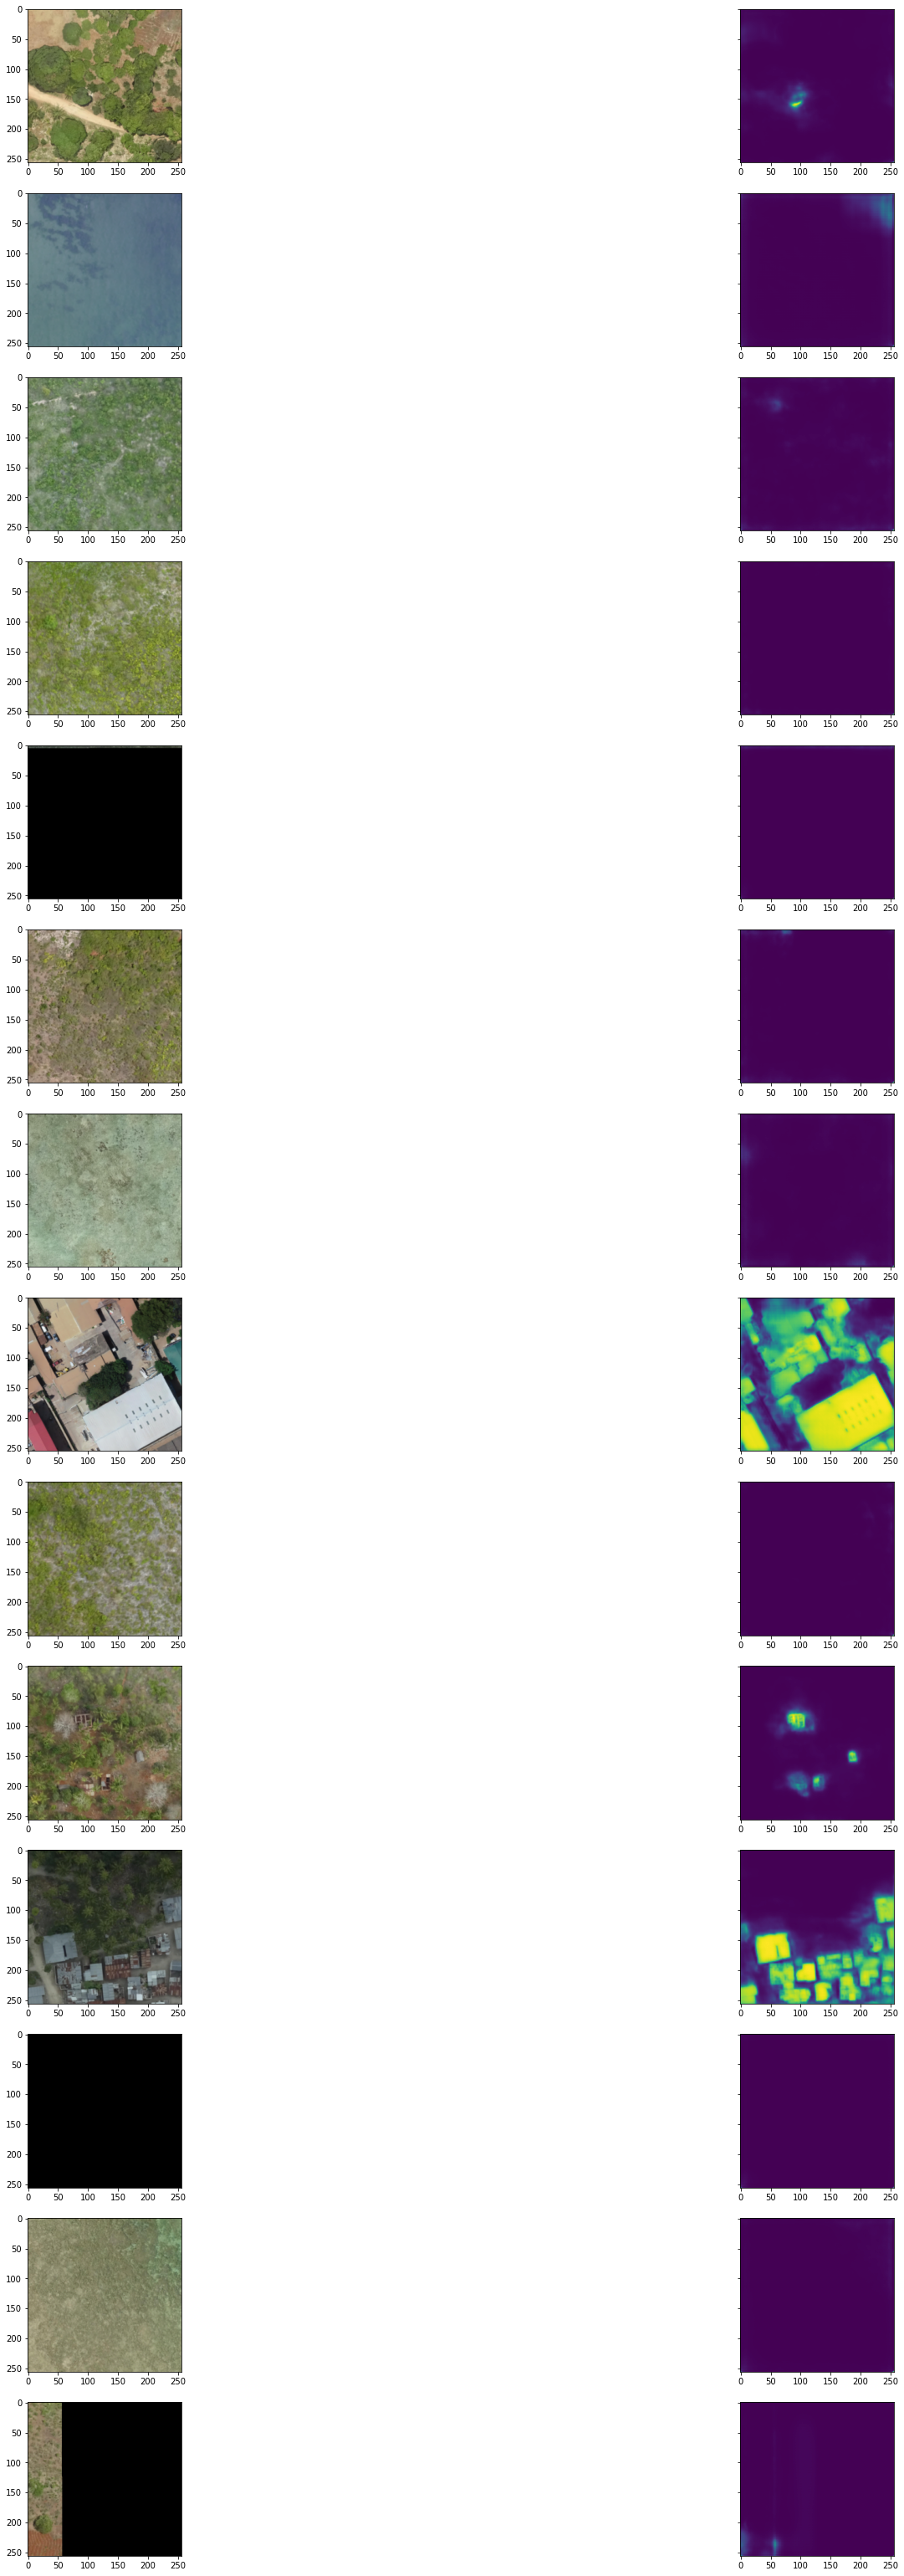

In [74]:
res = predict_and_show_random_images(model, 14, width, height, channel)

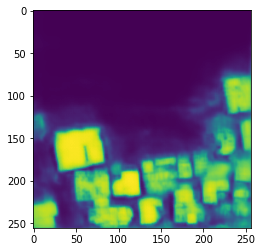

In [76]:
plt.imshow(res['predictions'][10])

In [77]:
res['predictions'][10]

array([[0.01715916, 0.01768255, 0.01616594, ..., 0.00659764, 0.00996819,
        0.02914697],
       [0.01006779, 0.00977376, 0.00828612, ..., 0.00351626, 0.00443125,
        0.00726768],
       [0.01233101, 0.00745219, 0.01081809, ..., 0.00273219, 0.00376371,
        0.00496587],
       ...,
       [0.71603125, 0.7441637 , 0.75512147, ..., 0.49098766, 0.49688524,
        0.4690418 ],
       [0.6654756 , 0.71291506, 0.75444597, ..., 0.47820804, 0.5054645 ,
        0.48876065],
       [0.63741744, 0.6690693 , 0.6830918 , ..., 0.49415025, 0.5165021 ,
        0.4863143 ]], dtype=float32)

In [37]:
im = res['predictions'][5] * 255

In [33]:
res['predictions'][5]

array([0.32577023, 0.25012204, 0.17696726, 0.12982771, 0.10371053,
       0.08914223, 0.08995938, 0.09787747, 0.12218791, 0.14762595,
       0.2014865 , 0.22273254, 0.28729975, 0.33021474, 0.46596244,
       0.5752549 , 0.6799877 , 0.62982196, 0.5683298 , 0.55356014,
       0.6463777 , 0.70817024, 0.79197073, 0.8351252 , 0.8467591 ,
       0.8571538 , 0.83600163, 0.83844674, 0.8436991 , 0.8483299 ,
       0.8339977 , 0.697648  , 0.5121098 , 0.38935128, 0.30904302,
       0.24115133, 0.24766663, 0.18371826, 0.1765266 , 0.14962855,
       0.16083813, 0.13910434, 0.13057041, 0.1318928 , 0.13811582,
       0.14081857, 0.157969  , 0.1592274 , 0.14722654, 0.12644553,
       0.11917496, 0.11416572, 0.11711684, 0.1168907 , 0.13991654,
       0.14782849, 0.18574637, 0.20128983, 0.2128891 , 0.17565888,
       0.17046157, 0.14530903, 0.15204293, 0.1301179 , 0.12303841,
       0.11028165, 0.09663841, 0.08659056, 0.08892086, 0.09407932,
       0.09367293, 0.08548838, 0.0871318 , 0.08005363, 0.08419

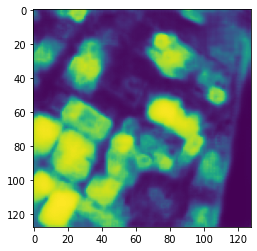

In [31]:
plt.imshow(im)

In [23]:
i = cv2.imwrite('temp.png', res['predictions'][5])

In [24]:
img = cv2.imread('temp.png', cv2.IMREAD_GRAYSCALE)

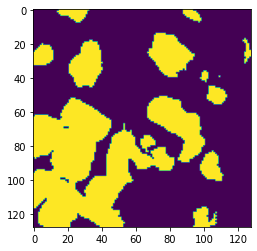

In [25]:
plt.imshow(img)

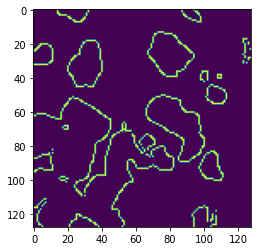

In [26]:
canny = cv2.Canny(img, 0, 1)
plt.imshow(canny)

In [34]:
kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])

In [48]:
im = cv2.filter2D(img, -1, kernel)

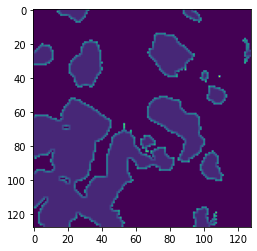

In [49]:
plt.imshow(im)

In [53]:
im.flatten().unique()

AttributeError: 'numpy.ndarray' object has no attribute 'unique'

In [46]:
im.astype(np.uint8)

array([[111, 231, 210, ...,  35,  47, 127],
       [218, 108,  89, ..., 243, 232,  42],
       [233, 132,  94, ...,  20,   0,  26],
       ...,
       [106, 245, 193, ...,   6, 255,   4],
       [153,  21,  49, ...,  10, 238,  15],
       [149,  84,  30, ...,  13,  11,  71]], dtype=uint8)

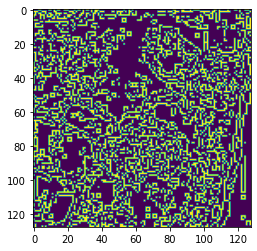

In [45]:
canny2 = cv2.Canny(im.astype(np.uint8), 220, 250)
plt.imshow(canny2)